## Kernel Thinning and Compress++ using the Sobolev kernel on [0,1]^2

In [8]:
import numpy as np
import jax
import jax.numpy as jnp
import time

from goodpoints.jax.kernel.sobol import SobolKernel
from goodpoints.jax.kt import kt
from goodpoints.jax.compress import kt_compresspp
from goodpoints.jax.mmd import compute_mmd

import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
kernel = SobolKernel(2, s=1)

rng_gen = np.random.default_rng(42)
rng = jax.random.PRNGKey(rng_gen.integers(2**31))
q = 18
n = 2**q
m = 2**(q//2)
mean_zero = True
use_compress = True
p = jax.random.uniform(rng, (n, 2))
points = kernel.prepare_input(p)

INFO:2024-12-08 23:47:20,196:jax._src.xla_bridge:927: Unable to initialize backend 'cuda': 
2024-12-08 23:47:20,196 - INFO - Unable to initialize backend 'cuda': 
INFO:2024-12-08 23:47:20,197:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-12-08 23:47:20,197 - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2024-12-08 23:47:20,199:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-12-08 23:47:20,199 - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-12-08 23:47:20,200 - WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [ ]:
start_time = time.time()
if use_compress:
    coreset = kt_compresspp(kernel, points, np.ones(n) / n, rng_gen, 
                inflate_size=n, delta=0.5)
else:
    coreset = kt(kernel, points, np.ones(n) / n, 
                n, m, 0.5, rng_gen)
print(f'JAX version took: {time.time() - start_time}s')

2024-12-08 23:47:21,030 - INFO - Compress++ with 262144 points...
2024-12-08 23:47:21,134 - INFO - Compressing to 2^g sqrt(n) points...
2024-12-08 23:47:26,664 - INFO - Kernel thinning to sqrt(n) points...
2024-12-08 23:47:28,115 - INFO - KT-swap improvement...


JAX version took: 9.930764198303223s


In [5]:
from goodpoints.compress import compresspp_kt
start_time = time.time()
coreset_old = compresspp_kt(np.array(p, dtype=float), b'sobolev', 
                            k_params=np.array([1.0]), g=4, mean0=mean_zero)
print(f'Cython version took: {time.time() - start_time}s')

Cython version took: 92.07866072654724s


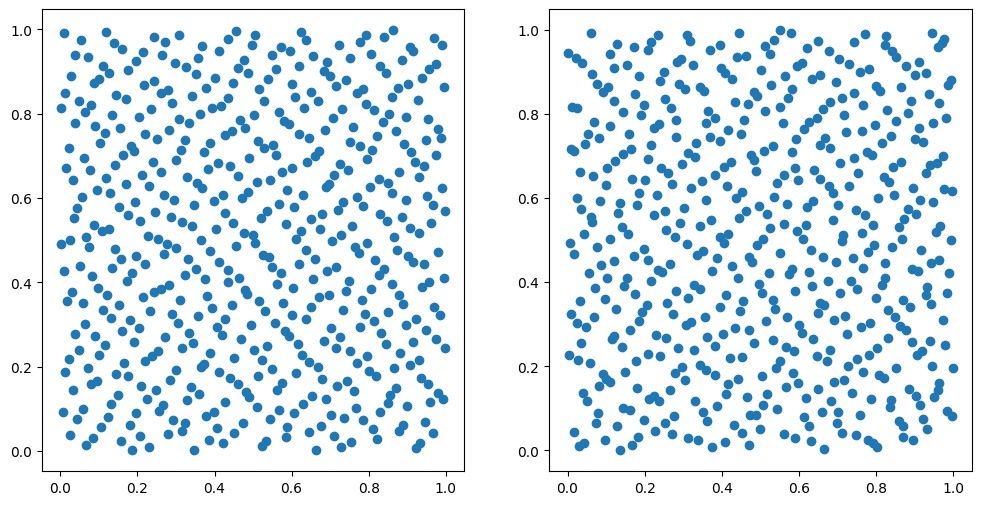

In [6]:
import matplotlib.pyplot as plt

def plot():
    figsize = 6
    fig, axes = plt.subplots(1, 2, figsize=(figsize*2,figsize))
    axes[0].scatter(p[coreset, 0], p[coreset, 1])
    axes[1].scatter(p[coreset_old, 0], p[coreset_old, 1])

plot()

In [7]:
for i, cur_coreset in enumerate([coreset, coreset_old]):
    mmd_input = compute_mmd(kernel, points.subset(cur_coreset),
                            points2=points, mode='full')
    mmd_P = compute_mmd(kernel, points.subset(cur_coreset), mode='mean-zero')
    ver = 'JAX' if i == 0 else 'Cython'
    print(f'[{ver} version] MMD to input points: {mmd_input}, MMD to P: {mmd_P}')

[JAX version] MMD to input points: 0.0012039425782859325, MMD to P: 0.0011680572060868144
[Cython version] MMD to input points: 0.0016845195787027478, MMD to P: 0.001639660564251244
